# Part 1: Introduction to Style Transfer

### 1.1: Explain the concept of style transfer and its importance in the field of computer vision.

• Not everyone's artistic abilities may be very advanced, but with the latest advances in technologies such as style transfer, anyone can produce an artistic work. AI and Computer Vision help you with this.

### 1.2: Describe the difference between content and style in an image.

• Style transfer is based on separating the content and style of an image. Given a content image and a style image, it is intended to create a new target image that should contain the content and style components we want:

--> objects and their arrangement are similar to that of the content image

--> style, colors, and textures are similar to the style image

### 1.3: Discuss the various applications of style transfer in the fields of art, photography, and advertising.

### HOW TO RESTYLE APPS
In this section, we show how style transfer can be applied to three kinds of mobile apps: apps that use a static set of graphical assets, and finally apps that generate interfaces dynamically.
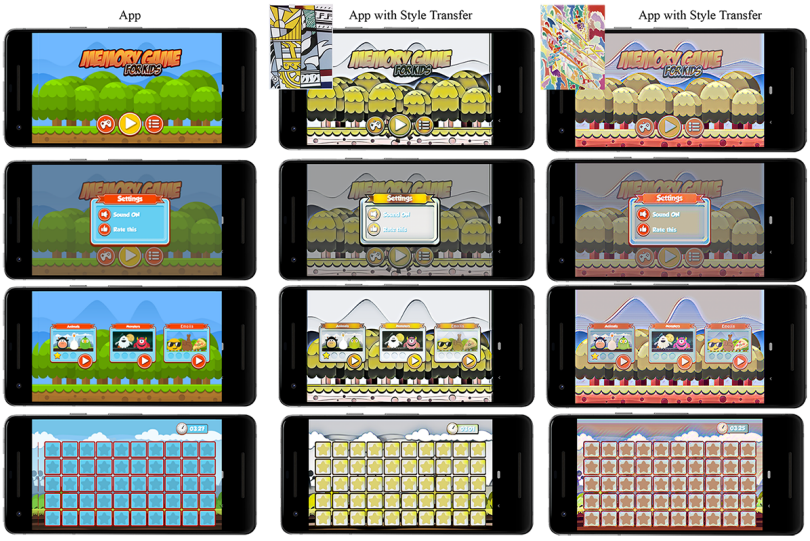

# Part 2: Implementing Style Transfer using PyTorch

In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load VGG19 Model

Note: I used the Pretrained model because my computer's ram is not good and I don't have much time for training.

In [2]:
vgg = models.vgg19(pretrained=True).features
    
for param in vgg.parameters():
    param.requires_grad_(False)

C:\Users\ataka\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ataka\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG19 is can using CUDA, but it is not installed in my computer so VGG19 will use my CPU

In [3]:
# move the model to GPU, if available
device = torch.device("cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [8]:
# load in content and style image
content = load_image('images/content/athene.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/style/style10.jpg', shape=content.shape[-2:]).to(device)

In [9]:
def im_convert(tensor): # converting it from a Tensor image to a NumPy image for display
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

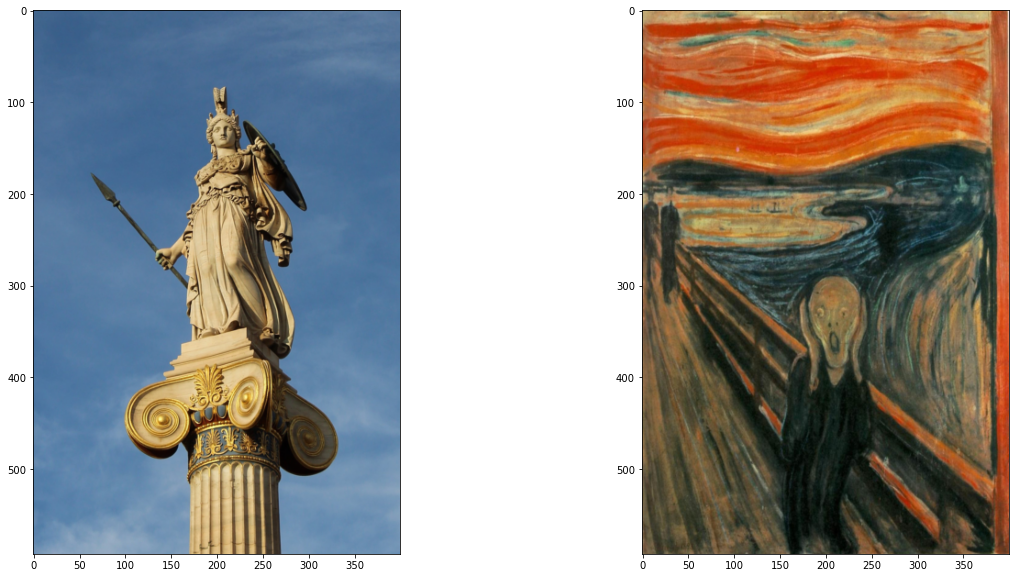

In [10]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [12]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

I am working with conv2D layers so I adjust these layers according to the model

In [13]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'} ## content representation
        
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## Gram Matrix
Gram Matrix is used to find error values.
The output of each convolutional layer is a Tensor with dimensions associated with batch_size, depth, d, and some height and width (h, w).

In [14]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()

    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [15]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
target = content.clone().requires_grad_(True).to(device)

### Losses and Weights
#### Individual Layer Style Weights
Each layer has an option to weight the style representation. It is recommended to use a range of 0-1 to weight these layers.

By weighting the earlier layers (conv1_1 and conv2_1) more, you can expect to get larger style artifacts in your resulting target image.

#### Content and Style Weight
It's better to leave content_weight = 1 and set style_weight to see how styled your final image is.

In [16]:
# weights for each style layer 
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # content image option
style_weight = 1e6  # style image option

I exclude "conv4_2" because we will use "conv4_2" to find the total loss

Total loss:  41229644.0


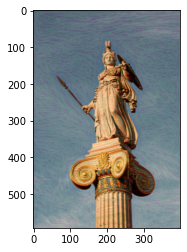

Total loss:  18993252.0


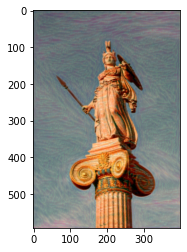

Total loss:  10223595.0


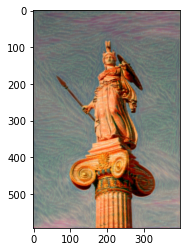

In [17]:
show_every = 200 # for displaying the target image, intermittently

optimizer = optim.Adam([target], lr=0.003)
steps = 600  # decide how many iterations to update your image

for i in range(1, steps+1):
    target_features = get_features(target, vgg) # get the features from your target image
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # the content loss

    style_loss = 0 # initialize the style loss to 0
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

# Part 3 (Optional): Tensorflow NST

In [23]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [24]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        return PIL.Image.fromarray(tensor)

In [25]:
content_path = 'images/content/athene.jpg'
style_path = 'images/style/style10.jpg'

In [27]:
def load_img(path_to_img):
    max_dim = 400
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [30]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

        plt.imshow(image)

        if title:
            plt.title(title)

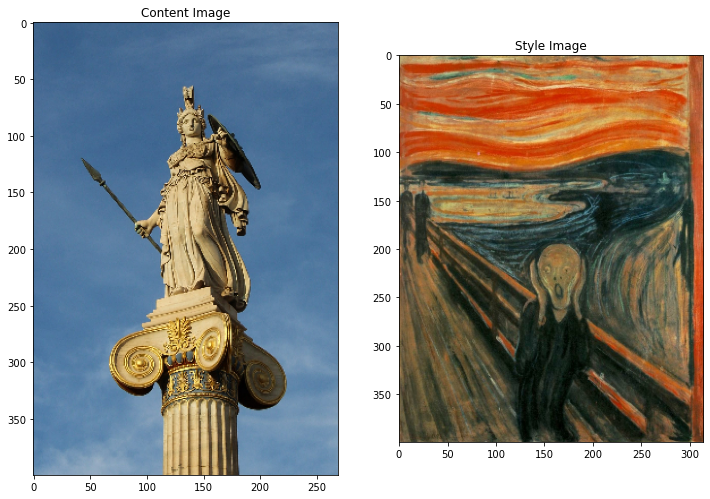

In [31]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

Note: I used the Pretrained model because my computer's ram is not good and I don't have much time for training.

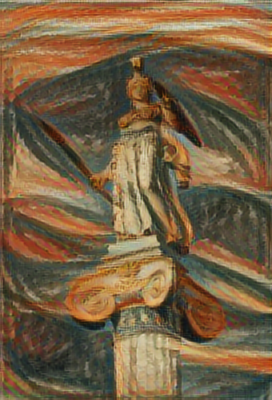

In [34]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# Part 4 (Optional): Advanced Topics in Style Transfer (SANET)

## Training Section

In [ ]:
import torch

def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def mean_variance_norm(feat):
    size = feat.size()
    mean, std = calc_mean_std(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat

def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std

import torch.nn as nn

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

class SANet(nn.Module):
    def __init__(self, in_planes):
        super(SANet, self).__init__()
        self.f = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.g = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = nn.Softmax(dim = -1)
        self.out_conv = nn.Conv2d(in_planes, in_planes, (1, 1))
    
    def forward(self, content, style):
        F = self.f(mean_variance_norm(content))
        G = self.g(mean_variance_norm(style))
        H = self.h(style)
        b, c, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        b, c, h, w = G.size()
        G = G.view(b, -1, w * h)
        S = torch.bmm(F, G)
        S = self.sm(S)
        b, c, h, w = H.size()
        H = H.view(b, -1, w * h)
        O = torch.bmm(H, S.permute(0, 2, 1))
        b, c, h, w = content.size()
        O = O.view(b, c, h, w)
        O = self.out_conv(O)
        O += content
        return O

class Transform(nn.Module):
    def __init__(self, in_planes):
        super(Transform, self).__init__()
        self.sanet4_1 = SANet(in_planes = in_planes)
        self.sanet5_1 = SANet(in_planes = in_planes)
        self.upsample5_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_planes, in_planes, (3, 3))
    
    def forward(self, content4_1, style4_1, content5_1, style5_1):
        return self.merge_conv(self.merge_conv_pad(self.sanet4_1(content4_1, style4_1) + self.upsample5_1(self.sanet5_1(content5_1, style5_1))))

class Net(nn.Module):
    def __init__(self, encoder, decoder, start_iter):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.enc_5 = nn.Sequential(*enc_layers[31:44])  # relu4_1 -> relu5_1
        #transform
        self.transform = Transform(in_planes = 512)
        self.decoder = decoder
        if(start_iter > 0):
            self.transform.load_state_dict(torch.load('transformer_iter_' + str(start_iter) + '.pth'))
            self.decoder.load_state_dict(torch.load('decoder_iter_' + str(start_iter) + '.pth'))
        self.mse_loss = nn.MSELoss()
        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4', 'enc_5']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1, relu5_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(5):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def calc_content_loss(self, input, target, norm = False):
        if(norm == False):
            return self.mse_loss(input, target)
        else:
            return self.mse_loss(mean_variance_norm(input), mean_variance_norm(target))

    def calc_style_loss(self, input, target):
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)
    
    def forward(self, content, style):
        style_feats = self.encode_with_intermediate(style)
        content_feats = self.encode_with_intermediate(content)
        stylized = self.transform(content_feats[3], style_feats[3], content_feats[4], style_feats[4])
        g_t = self.decoder(stylized)
        g_t_feats = self.encode_with_intermediate(g_t)
        loss_c = self.calc_content_loss(g_t_feats[3], content_feats[3], norm = True) + self.calc_content_loss(g_t_feats[4], content_feats[4], norm = True)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 5):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        """IDENTITY LOSSES"""
        Icc = self.decoder(self.transform(content_feats[3], content_feats[3], content_feats[4], content_feats[4]))
        Iss = self.decoder(self.transform(style_feats[3], style_feats[3], style_feats[4], style_feats[4]))
        l_identity1 = self.calc_content_loss(Icc, content) + self.calc_content_loss(Iss, style)
        Fcc = self.encode_with_intermediate(Icc)
        Fss = self.encode_with_intermediate(Iss)
        l_identity2 = self.calc_content_loss(Fcc[0], content_feats[0]) + self.calc_content_loss(Fss[0], style_feats[0])
        for i in range(1, 5):
            l_identity2 += self.calc_content_loss(Fcc[i], content_feats[i]) + self.calc_content_loss(Fss[i], style_feats[i])
        return loss_c, loss_s, l_identity1, l_identity2

#----------------------------------------------------------------------------#

def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0


class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

import argparse
import os
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data as data
from PIL import Image
from PIL import ImageFile
from tensorboardX import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

cudnn.benchmark = True
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Disable OSError: image file is truncated


def train_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)


class TrainingDataset(data.Dataset):
    def __init__(self, root, transform):
        super(TrainingDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'TrainingDataset'


def adjust_learning_rate(optimizer, iteration_count):
    lr = args.lr / (1.0 + args.lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content_dir', type=str, default='./train2014',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_dir', type=str, default='./train',
                    help='Directory path to a batch of style images')
parser.add_argument('--vgg', type=str, default='./vgg_normalised.pth')

# training options
parser.add_argument('--save_dir', default='./experiments',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--lr_decay', type=float, default=5e-5)
parser.add_argument('--max_iter', type=int, default=160000)
parser.add_argument('--batch_size', type=int, default=5)
parser.add_argument('--style_weight', type=float, default=3.0)
parser.add_argument('--content_weight', type=float, default=1.0)
parser.add_argument('--n_threads', type=int, default=16)
parser.add_argument('--save_model_interval', type=int, default=1000)
parser.add_argument('--start_iter', type=float, default=0)
args = parser.parse_args('')

device = torch.device('cuda')

decoder = decoder
vgg = vgg

vgg.load_state_dict(torch.load(args.vgg))
vgg = nn.Sequential(*list(vgg.children())[:44])
network = Net(vgg, decoder, args.start_iter)
network.train()
network.to(device)

content_tf = train_transform()
style_tf = train_transform()

content_dataset = TrainingDataset(args.content_dir, content_tf)
style_dataset = TrainingDataset(args.style_dir, style_tf)

content_iter = iter(data.DataLoader(
    content_dataset, batch_size=args.batch_size,
    sampler=InfiniteSamplerWrapper(content_dataset),
    num_workers=args.n_threads))
style_iter = iter(data.DataLoader(
    style_dataset, batch_size=args.batch_size,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=args.n_threads))

optimizer = torch.optim.Adam([
                              {'params': network.decoder.parameters()},
                              {'params': network.transform.parameters()}], lr=args.lr)

if(args.start_iter > 0):
    optimizer.load_state_dict(torch.load('optimizer_iter_' + str(args.start_iter) + '.pth'))

for i in tqdm(range(args.start_iter, args.max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)
    loss_c, loss_s, l_identity1, l_identity2 = network(content_images, style_images)
    loss_c = args.content_weight * loss_c
    loss_s = args.style_weight * loss_s
    loss = loss_c + loss_s + l_identity1 * 50 + l_identity2 * 1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        state_dict = decoder.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict,
                   '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                           i + 1))
        state_dict = network.transform.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict,
                   '{:s}/transformer_iter_{:d}.pth'.format(args.save_dir,
                                                           i + 1))
        state_dict = optimizer.state_dict()
        torch.save(state_dict,
                   '{:s}/optimizer_iter_{:d}.pth'.format(args.save_dir,
                                                           i + 1))
writer.close()

NOTE: SANET Training code is here but I didn't train the model because Train Dataset is so big for my computer's local disk and RAM. So, I used pretrained model.

There are three model in the code.
-- > Decoder
-- > Transformer
-- > VGG_Normalized

## Predict Section

In [8]:
import argparse
import os
import torch
import torch.nn as nn
from PIL import Image
from os.path import basename
from os.path import splitext
from torchvision import transforms
from torchvision.utils import save_image

def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def mean_variance_norm(feat):
    size = feat.size()
    mean, std = calc_mean_std(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

class SANet(nn.Module):
    
    def __init__(self, in_planes):
        super(SANet, self).__init__()
        self.f = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.g = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = nn.Softmax(dim = -1)
        self.out_conv = nn.Conv2d(in_planes, in_planes, (1, 1))
        
    def forward(self, content, style):
        F = self.f(mean_variance_norm(content))
        G = self.g(mean_variance_norm(style))
        H = self.h(style)
        b, c, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        b, c, h, w = G.size()
        G = G.view(b, -1, w * h)
        S = torch.bmm(F, G)
        S = self.sm(S)
        b, c, h, w = H.size()
        H = H.view(b, -1, w * h)
        O = torch.bmm(H, S.permute(0, 2, 1))
        b, c, h, w = content.size()
        O = O.view(b, c, h, w)
        O = self.out_conv(O)
        O += content
        return O

class Transform(nn.Module):
    def __init__(self, in_planes):
        super(Transform, self).__init__()
        self.sanet4_1 = SANet(in_planes = in_planes)
        self.sanet5_1 = SANet(in_planes = in_planes)
        self.upsample5_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_planes, in_planes, (3, 3))
    def forward(self, content4_1, style4_1, content5_1, style5_1):
        return self.merge_conv(self.merge_conv_pad(self.sanet4_1(content4_1, style4_1) + self.upsample5_1(self.sanet5_1(content5_1, style5_1))))

def test_transform():
    transform_list = []
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

parser = argparse.ArgumentParser()

# Basic options
parser.add_argument('--content', type=str, default = 'images/content/athene.jpg',
                    help='File path to the content image')
parser.add_argument('--style', type=str, default = 'images/style/style10.jpg',
                    help='File path to the style image, or multiple style \
                    images separated by commas if you want to do style \
                    interpolation or spatial control')
parser.add_argument('--steps', type=str, default = 1)
parser.add_argument('--vgg', type=str, default = 'vgg_normalised.pth')
parser.add_argument('--decoder', type=str, default = 'decoder_iter_500000.pth')
parser.add_argument('--transform', type=str, default = 'transformer_iter_500000.pth')

# Additional options
parser.add_argument('--save_ext', default = '.jpg',
                    help='The extension name of the output image')
parser.add_argument('--output', type=str, default = 'output',
                    help='Directory to save the output image(s)')

# Advanced options

args = parser.parse_args('')

device = torch.device("cpu")

if not os.path.exists(args.output):
    os.mkdir(args.output)

decoder = decoder
transform = Transform(in_planes = 512)
vgg = vgg

decoder.eval()
transform.eval()
vgg.eval()

decoder.load_state_dict(torch.load(args.decoder))
transform.load_state_dict(torch.load(args.transform))
vgg.load_state_dict(torch.load(args.vgg))

norm = nn.Sequential(*list(vgg.children())[:1])
enc_1 = nn.Sequential(*list(vgg.children())[:4])  # input -> relu1_1
enc_2 = nn.Sequential(*list(vgg.children())[4:11])  # relu1_1 -> relu2_1
enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

norm.to(device)
enc_1.to(device)
enc_2.to(device)
enc_3.to(device)
enc_4.to(device)
enc_5.to(device)
transform.to(device)
decoder.to(device)

content_tf = test_transform()
style_tf = test_transform()

content = content_tf(Image.open(args.content))
style = style_tf(Image.open(args.style))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)

with torch.no_grad():

    for x in range(args.steps):

        print('iteration ' + str(x))
        
        Content4_1 = enc_4(enc_3(enc_2(enc_1(content))))
        Content5_1 = enc_5(Content4_1)
    
        Style4_1 = enc_4(enc_3(enc_2(enc_1(style))))
        Style5_1 = enc_5(Style4_1)
    
        content = decoder(transform(Content4_1, Style4_1, Content5_1, Style5_1))

        content.clamp(0, 255)

    content = content.cpu()
    
    output_name = '{:s}/{:s}_stylized_{:s}{:s}'.format(
                args.output, splitext(basename(args.content))[0],
                splitext(basename(args.style))[0], args.save_ext
            )
    save_image(content, output_name)

iteration 0


In [2]:
from IPython.display import Image

Image(url="output/athene_stylized_style10.jpg", width=500, height=500)

# Appendix: My Comments

## 3 different Neural Style Transfer models were used for this task.

### Part 2 - PyTorch VGG19 Model: 
Can produce output at medium speed. Total loss weights of outputs can be reduced by increasing the number of iterations, but output generation time will increase. 

The number of iterations can be determined according to the balance of time and success.

### Part 3 - Fast Tensorflow Model: 
It can produce output very quickly, but the output has high total loss weights and low resolution.
It can be used to get fast results regardless of the error rate.

### Part 4 - SANET (Decoder, Transformers, VGG_Normalized) Model:
It is the model that produces the highest resolution and the lowest total loss weights. It can be called the most successful model, but the output generation time is higher than other models.
It can be used for situations where high success is desired.